In [ ]:
import torch
import torch.nn as nn
import math

# Aide pour dire au modèle l'ordre des frames (1, 2, 3...)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x shape: (Batch, Seq_Len, Dim)
        return x + self.pe[:, :x.size(1)]

class NFLSeq2SeqModel(nn.Module):
    def __init__(self, receiver_dim=90, defender_dim=9, embed_dim=64, num_heads=4, num_decoder_layers=2):
        super().__init__()
        self.embed_dim = embed_dim
        
        # --- PARTIE ENCODEUR ---
        self.receiver_embedding = nn.Linear(receiver_dim, embed_dim)
        self.defender_embedding = nn.Linear(defender_dim, embed_dim)
        # Attention "Interne" (Le receveur regarde les défenseurs)
        self.encoder_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        
        # --- PARTIE DÉCODEUR ---
        # On projette le point (dx, dy) en vecteur 64
        self.decoder_input_embedding = nn.Linear(2, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        
        # Le Décodeur Transformer standard
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        # Tête de prédiction finale
        self.output_head = nn.Linear(embed_dim, 2) # Sort (dx, dy)

    def generate_square_subsequent_mask(self, sz):
        # Masque pour empêcher de regarder le futur pendant l'entrainement
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src_rec, src_def, tgt_seq):
        """
        src_rec: Historique Receveur (Batch, 90)
        src_def: Contexte Défenseurs (Batch, 22, 9)
        tgt_seq: Séquence cible future (Batch, T_future, 2) -> Ce qu'on doit apprendre à prédire
        """
        # 1. ENCODAGE
        # Query = Le receveur (Batch, 1, 64)
        query = self.receiver_embedding(src_rec).unsqueeze(1)
        # Keys = Les défenseurs (Batch, 22, 64)
        keys = self.defender_embedding(src_def)
        
        # Le receveur 'calcule' son contexte tactique
        memory, _ = self.encoder_attention(query, keys, keys)
        # memory est maintenant le "résumé tactique" (Batch, 1, 64)
        
        # 2. DÉCODAGE (Training avec "Teacher Forcing")
        # On prépare l'entrée du décodeur (Embeddings + Position)
        tgt_emb = self.decoder_input_embedding(tgt_seq)
        tgt_emb = self.pos_encoder(tgt_emb)
        
        # Création du masque causal (pour ne pas tricher en regardant la frame T+1 quand on est à T)
        seq_len = tgt_seq.size(1)
        tgt_mask = self.generate_square_subsequent_mask(seq_len).to(tgt_seq.device)
        
        # Le Décodeur regarde : 
        # A) La séquence cible passée (tgt_emb)
        # B) La mémoire de l'encodeur (memory)
        output = self.decoder(tgt_emb, memory, tgt_mask=tgt_mask)
        
        # 3. PRÉDICTION
        prediction = self.output_head(output) # (Batch, Seq_Len, 2)
        return prediction

    def predict_future(self, src_rec, src_def, num_steps=10):
        """
        Fonction spéciale pour l'INFÉRENCE (Visualisation)
        Génère frame par frame sans connaitre la réponse.
        """
        self.eval()
        with torch.no_grad():
            # 1. Encodage (identique)
            query = self.receiver_embedding(src_rec).unsqueeze(1)
            keys = self.defender_embedding(src_def)
            memory, _ = self.encoder_attention(query, keys, keys)
            
            # 2. Boucle de Génération
            # On commence avec un déplacement nul (0, 0)
            current_input = torch.zeros(src_rec.size(0), 1, 2).to(src_rec.device)
            predictions = []
            
            for _ in range(num_steps):
                # Préparer l'entrée
                tgt_emb = self.decoder_input_embedding(current_input)
                tgt_emb = self.pos_encoder(tgt_emb)
                
                # Le décodeur prédit la suite
                # Pas besoin de masque ici car on avance pas à pas
                out = self.decoder(tgt_emb, memory)
                
                # On prend juste le dernier point prédit
                next_point = self.output_head(out[:, -1, :]).unsqueeze(1) # (Batch, 1, 2)
                
                predictions.append(next_point)
                
                # RÉCURSIVITÉ : Le point prédit devient l'entrée de la prochaine étape
                current_input = torch.cat([current_input, next_point], dim=1)
            
            # On colle tout (Batch, num_steps, 2)
            return torch.cat(predictions, dim=1)

In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import glob
import os

# --- CONFIGURATION ---
# On cherche les fichiers dans le dossier nfl-big-data-bowl-2026-prediction puis dans train/

INPUT_FILES = glob.glob("../nfl-big-data-bowl-2026-prediction/train/input_*.csv")
DATASET_FILE = '../nfl_dataset_seq2seq.pt'
HISTORY_SIZE = 10 

# Normalisation
MAX_SPEED = 13.0
MAX_ACCEL = 10.0
MAX_DIST = 50.0

data_list = []

print(f"Génération du dataset : Seq2Seq (Tous les 'player_to_predict')...")

def get_angle_features(degree_val):
    rad = np.radians(degree_val)
    return np.sin(rad), np.cos(rad)

for in_file in INPUT_FILES:
    # Trouver le fichier output
    folder, filename = os.path.split(in_file)
    out_filename = filename.replace("input_", "output_")
    out_file = os.path.join(folder, out_filename)
    
    if not os.path.exists(out_file): continue
    
    df_in = pd.read_csv(in_file)
    df_out = pd.read_csv(out_file)
    
    common_plays = set(df_in['play_id']).intersection(df_out['play_id'])
    
    for play_id in tqdm(common_plays, leave=False, desc=filename):
        # Filtrer le play complet
        play_in = df_in[(df_in['game_id'] == df_in['game_id'].iloc[0]) & (df_in['play_id'] == play_id)].sort_values('frame_id')
        play_out = df_out[(df_out['game_id'] == df_out['game_id'].iloc[0]) & (df_out['play_id'] == play_id)].sort_values('frame_id')
        
        # On cherche TOUS les joueurs à prédire (pas juste le receveur visé)
        # On prend les IDs uniques qui sont marqués True à n'importe quel moment du play
        candidates = play_in[play_in['player_to_predict'] == True]['nfl_id'].unique()
        
        for target_id in candidates:
            # 1. Récupérer l'historique de CE joueur
            player_track = play_in[play_in['nfl_id'] == target_id]
            
            # S'il n'a pas assez d'historique (ex: vient de rentrer sur le terrain), on skip
            if len(player_track) < HISTORY_SIZE: continue
            
            # Séquence Input (les 10 dernières frames connues)
            history_seq = player_track.iloc[-HISTORY_SIZE:]
            current_pos = history_seq.iloc[-1]
            
            # 2. Récupérer son Futur (Label)
            future_track = play_out[play_out['nfl_id'] == target_id]
            if future_track.empty: continue # Pas de données futures dispos
            
            # APRÈS : On prend les 10 prochaines frames (ou moins si fin du play)
            future_seq = future_track.iloc[:10] 
            
            labels_list = []
            prev_x, prev_y = current_pos['x'], current_pos['y']
            
            for _, row in future_seq.iterrows():
                # On prédit le déplacement relatif frame par frame
                dx = row['x'] - prev_x
                dy = row['y'] - prev_y
                labels_list.append([dx, dy])
                # Mise à jour pour la frame suivante
                prev_x, prev_y = row['x'], row['y']
            
            # Padding si moins de 10 frames futures
            while len(labels_list) < 10:
                labels_list.append([0.0, 0.0])
                
            label = torch.tensor(labels_list, dtype=torch.float32) # Shape (10, 2)
            
            # --- CONSTRUCTION DES FEATURES ---
            
            # A. QUERY (Le joueur cible lui-même) : Séquence aplatie
            # Taille = 10 frames * 9 features = 90
            rec_features = []
            ball_x, ball_y = current_pos['ball_land_x'], current_pos['ball_land_y']
            
            for _, row in history_seq.iterrows():
                sin_d, cos_d = get_angle_features(row['dir'])
                sin_o, cos_o = get_angle_features(row['o'])
                
                # Est-ce que le joueur cible est en Attaque ?
                is_offense = 1.0 if play_in[play_in['nfl_id'] == target_id]['player_side'].iloc[0] == 'Offense' else 0.0

                feats = [
                    row['s'] / MAX_SPEED,
                    row['a'] / MAX_ACCEL,
                    sin_d, cos_d,
                    sin_o, cos_o,
                    (ball_x - row['x']) / MAX_DIST,
                    (ball_y - row['y']) / MAX_DIST,
                    is_offense
                ]
                rec_features.extend(feats)
            
            query = torch.tensor(rec_features, dtype=torch.float32)

            # B. KEYS (Le Contexte : TOUS les autres joueurs autour)
            # Important : On calcule la position relative par rapport au target_id actuel
            current_frame_id = current_pos['frame_id']
            
            # On prend tout le monde SAUF le joueur cible lui-même
            others = play_in[(play_in['frame_id'] == current_frame_id) & (play_in['nfl_id'] != target_id)]
            
            keys_list = []
            for _, other_row in others.iterrows():
                sin_d, cos_d = get_angle_features(other_row['dir'])
                sin_o, cos_o = get_angle_features(other_row['o'])
                
                # Est-ce un coéquipier ?
                # On compare le 'player_side' du voisin avec celui du target_id
                side_target = play_in[play_in['nfl_id'] == target_id]['player_side'].iloc[0]
                side_other = other_row['player_side']
                
                is_teammate = 1.0 if side_target == side_other else 0.0
                
                k_feats = [
                    (other_row['x'] - current_pos['x']) / MAX_DIST,
                    (other_row['y'] - current_pos['y']) / MAX_DIST,
                    other_row['s'] / MAX_SPEED,
                    other_row['a'] / MAX_ACCEL,
                    sin_d, cos_d,
                    sin_o, cos_o,
                    is_teammate # <--- NOUVELLE FEATURE
                ] 
                keys_list.append(k_feats)
            
            # Padding à 21 autres joueurs (11 def + 10 off max)
            # On augmente un peu la taille du padding pour être sûr
            while len(keys_list) < 22:
                keys_list.append([0.0] * 9)
                
            keys = torch.tensor(keys_list[:22], dtype=torch.float32) # (22, 9)

            data_list.append((query, keys, label))

            # 2. DATA AUGMENTATION : MIROIR VERTICAL (Flip Y)
            # L'axe Y va de 0 à 53.3. Inverser veut dire : y_new = 53.3 - y
            
            # Pour faire ça proprement sur les Tensors déjà créés :
            # Query (90 features) : [speed, accel, sin_d, cos_d, sin_o, cos_o, dist_x, dist_y] répété 10 fois
            # Inverser Y change le signe de : dist_y (feature 7) et cos_d/cos_o (composante verticale de l'angle)
            
            query_flip = query.clone()
            keys_flip = keys.clone()
            label_flip = label.clone()
            
            # Inverse la distance Y (Feature index 7, 15, 23... toutes les 8 features)
            # Note : Index 7 est dist_y. Index 3 est cos_d (direction Y). Index 5 est cos_o (orientation Y)
            
            # A. Inversion pour le Receveur (Query) - C'est une séquence aplatie
            # On inverse le signe de la composante Y (cosinus et distance Y)
            for i in range(10): # Pour les 10 frames
                base = i * 9
                query_flip[base + 3] *= -1 # Inverse Cos Direction (Y component)
                query_flip[base + 5] *= -1 # Inverse Cos Orientation (Y component)
                query_flip[base + 7] *= -1 # Inverse Dist Y
                
            # B. Inversion pour les Défenseurs (Keys) - (22, 9)
            # Features : [rel_x, rel_y, s, a, sin_d, cos_d, sin_o, cos_o]
            # Index à inverser : 1 (rel_y), 5 (cos_d), 7 (cos_o)
            keys_flip[:, 1] *= -1
            keys_flip[:, 5] *= -1
            keys_flip[:, 7] *= -1
            
            # C. Inversion du Label (x, y)
            label_flip[1] *= -1 # Inverse l'offset Y à prédire

            # Ajouter la version miroir
            data_list.append((query_flip, keys_flip, label_flip))

# Sauvegarde
print(f"Sauvegarde de {len(data_list)} exemples (Attaquants + Défenseurs)...")
if len(data_list) > 0:
    final_queries = torch.stack([x[0] for x in data_list])
    final_keys = torch.stack([x[1] for x in data_list])
    final_labels = torch.stack([x[2] for x in data_list])
    
    torch.save({'queries': final_queries, 'keys': final_keys, 'labels': final_labels}, DATASET_FILE)
    print(f"Dataset prêt : {DATASET_FILE}")
else:
    print("Aucun exemple généré.")

Génération du dataset : Multi-Agents (Tous les 'player_to_predict')...


Sauvegarde de 6324 exemples (Attaquants + Défenseurs)...
Dataset prêt : ../nfl_dataset_v4_MULTI_AGENT.pt


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 1. Classe Dataset Intelligente (Normalisation)
class NFLDataset(Dataset):
    def __init__(self, pt_file):
        print(f"Chargement du dataset : {pt_file} ...")
        data = torch.load(pt_file)
        
        self.queries = data['queries']
        self.keys = data['keys']
        self.labels = data['labels']
        
        # Vérification des dimensions pour être sûr
        print(f"    Chargé {len(self.labels)} exemples.")
        print(f"   - Query Shape : {self.queries.shape} (Doit être N, 90)")
        print(f"   - Keys Shape  : {self.keys.shape}   (Doit être N, 22, 9)")
        print(f"   - Labels Shape: {self.labels.shape} (Doit être N, 2)")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # On clone juste les tenseurs. 
        # AUCUN CALCUL ICI car tout est déjà fait dans la génération V4.
        q = self.queries[idx].clone()
        k = self.keys[idx].clone()
        y = self.labels[idx].clone()

        return q, k, y

Chargement du dataset : ../nfl_dataset_v4_MULTI_AGENT.pt ...
    Chargé 6324 exemples.
   - Query Shape : torch.Size([6324, 90]) (Doit être N, 90)
   - Keys Shape  : torch.Size([6324, 22, 9])   (Doit être N, 22, 9)
   - Labels Shape: torch.Size([6324, 10, 2]) (Doit être N, 2)
Dataset Total : 6324
Train set : 5059 (pour apprendre)
Val set   : 1265 (pour évaluer)
Entraînement...
Epoch [1/1000] | Train Loss: 0.0803 | Val Loss: 0.0350 | Avg Yards Error: 0.1865
Epoch [2/1000] | Train Loss: 0.0332 | Val Loss: 0.0224 | Avg Yards Error: 0.1390
Epoch [3/1000] | Train Loss: 0.0244 | Val Loss: 0.0178 | Avg Yards Error: 0.1241
Epoch [4/1000] | Train Loss: 0.0205 | Val Loss: 0.0166 | Avg Yards Error: 0.1165
Epoch [5/1000] | Train Loss: 0.0187 | Val Loss: 0.0153 | Avg Yards Error: 0.1073
Epoch [6/1000] | Train Loss: 0.0179 | Val Loss: 0.0151 | Avg Yards Error: 0.1114
Epoch [7/1000] | Train Loss: 0.0171 | Val Loss: 0.0145 | Avg Yards Error: 0.1020
Epoch [8/1000] | Train Loss: 0.0167 | Val Loss: 0.014

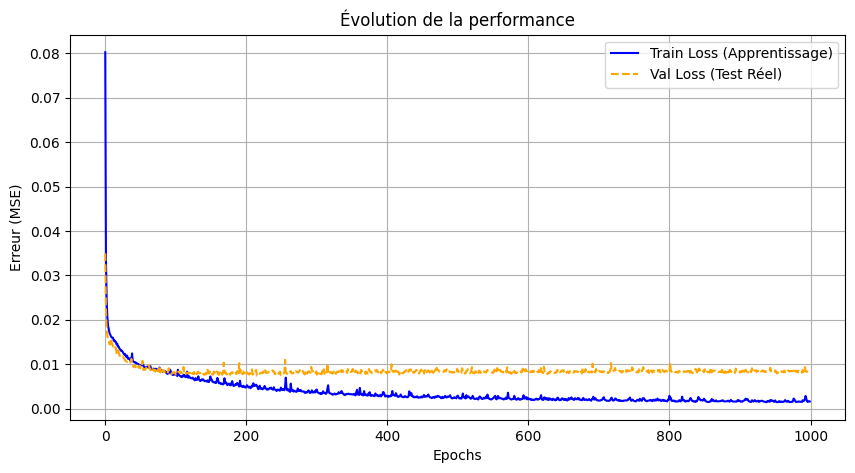

<Figure size 640x480 with 0 Axes>

In [ ]:
# 2. Chargement
from torch.utils.data import random_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Charger le dataset complet comme avant
full_dataset = NFLDataset('../nfl_dataset_v4_MULTI_AGENT.pt')

# 2. Calculer les tailles (80% Train, 20% Val)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

# 3. Diviser le dataset aléatoirement
train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

print(f"Dataset Total : {total_size}")
print(f"Train set : {len(train_subset)} (pour apprendre)")
print(f"Val set   : {len(val_subset)} (pour évaluer)")

# 4. Créer les DataLoaders distincts
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)


# 3. Modèle
# embed_dim=128 donne plus de capacité
# Mise à jour du modèle pour accepter les drapeaux d'équipe
model = NFLSeq2SeqModel(
    receiver_dim=90,  # 9 features * 10 frames (au lieu de 80)
    defender_dim=9,   # 8 features + 1 flag ami/ennemi (au lieu de 8)
    embed_dim=64,
    num_heads=2
)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()
num_epochs = 1000

# 4. Entraînement
print("Entraînement...")
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- PHASE 1 : ENTRAÎNEMENT (Sur les 80%) ---
    model.train() # Mode entraînement (active le dropout, etc.)
    running_loss = 0.0
    
    for queries, keys, labels in train_loader:
        optimizer.zero_grad()
        queries = queries.to(device)
        keys = keys.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        start_token = torch.zeros(batch_size, 1, 2).to(device)
        decoder_input = torch.cat([start_token, labels[:, :-1, :]], dim=1)
        
        # Forward
        predictions = model(queries, keys, decoder_input)
        
        # Loss
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # --- PHASE 2 : ÉVALUATION (Sur les 20%) ---
    model.eval() # Mode évaluation (fige le modèle)
    running_val_loss = 0.0
# Pour calculer une métrique "yards" approximative
    total_distance_error = 0.0 
    total_points = 0
    
    with torch.no_grad(): # Pas de gradients = économie mémoire
        for queries, keys, labels in val_loader:
            # 1. GPU / Device
            queries = queries.to(device)
            keys = keys.to(device)
            labels = labels.to(device)
            
            # 2. Préparer l'entrée du Décodeur (Comme à l'entraînement)
            # On aide le modèle en lui donnant la "vraie" frame précédente
            batch_size = labels.size(0)
            start_token = torch.zeros(batch_size, 1, 2).to(device)
            decoder_input = torch.cat([start_token, labels[:, :-1, :]], dim=1)
            
            # 3. Forward
            predictions = model(queries, keys, decoder_input)
            
            # 4. Loss
            loss = criterion(predictions, labels)
            running_val_loss += loss.item()
            
            # 5. Métrique Bonus : Erreur moyenne en Yards (Approx)
            # On calcule la distance euclidienne entre prédiction et réalité
            # sqrt((x_pred - x_real)^2 + (y_pred - y_real)^2)
            error = torch.sqrt(torch.sum((predictions - labels)**2, dim=2))
            total_distance_error += error.sum().item()
            total_points += error.numel() # Nombre total de points prédits
            
    avg_val_loss = running_val_loss / len(val_loader)
    avg_yards_error = total_distance_error / total_points if total_points > 0 else 0
    
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Avg Yards Error: {avg_yards_error:.4f}")

print("Entraînement terminé !")

# Petit bonus : Visualiser les courbes pour vérifier le sur-apprentissage (Overfitting)
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss (Apprentissage)', color='blue')
plt.plot(val_losses, label='Val Loss (Test Réel)', color='orange', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Erreur (MSE)')
plt.legend()
plt.title('Évolution de la performance')
plt.grid(True)
plt.show()
plt.savefig('../results/training_validation_loss.png')

In [9]:
#Sauvegarde du modèle entraîné
torch.save(model.state_dict(), '../models/nfl_attention_model_seq2seq.pth')

In [3]:
# --- CONSTANTES ---
HISTORY_SIZE = 10
MAX_SPEED = 13.0
MAX_ACCEL = 10.0
MAX_DIST = 50.0

def get_angle_features(degree_val):
    rad = np.radians(degree_val)
    return np.sin(rad), np.cos(rad)

def prepare_seq2seq_input(df, game_id, play_id, target_nfl_id):
    # Filtrer et trier
    play_data = df[(df['game_id'] == game_id) & (df['play_id'] == play_id)].sort_values('frame_id')
    player_track = play_data[play_data['nfl_id'] == target_nfl_id]
    
    if len(player_track) < HISTORY_SIZE: return None, None, None
    
    # Input Sequence (10 dernières frames)
    history_seq = player_track.iloc[-HISTORY_SIZE:]
    current_pos = history_seq.iloc[-1]
    
    # 1. Query (Receveur)
    rec_features = []
    ball_x, ball_y = current_pos['ball_land_x'], current_pos['ball_land_y']
    is_offense = 1.0 if current_pos['player_side'] == 'Offense' else 0.0
    
    for _, row in history_seq.iterrows():
        sin_d, cos_d = get_angle_features(row['dir'])
        sin_o, cos_o = get_angle_features(row['o'])
        feats = [
            row['s']/MAX_SPEED, row['a']/MAX_ACCEL,
            sin_d, cos_d, sin_o, cos_o,
            (ball_x - row['x'])/MAX_DIST, (ball_y - row['y'])/MAX_DIST,
            is_offense
        ]
        rec_features.extend(feats)
    query = torch.tensor(rec_features, dtype=torch.float32).unsqueeze(0) # (1, 90)

    # 2. Keys (Contexte Défenseurs/Alliés)
    current_frame_id = current_pos['frame_id']
    others = play_data[(play_data['frame_id'] == current_frame_id) & (play_data['nfl_id'] != target_nfl_id)]
    keys_list = []
    side_target = current_pos['player_side']
    
    for _, other_row in others.iterrows():
        sin_d, cos_d = get_angle_features(other_row['dir'])
        sin_o, cos_o = get_angle_features(other_row['o'])
        is_teammate = 1.0 if other_row['player_side'] == side_target else 0.0
        k_feats = [
            (other_row['x'] - current_pos['x'])/MAX_DIST, (other_row['y'] - current_pos['y'])/MAX_DIST,
            other_row['s']/MAX_SPEED, other_row['a']/MAX_ACCEL,
            sin_d, cos_d, sin_o, cos_o, is_teammate
        ]
        keys_list.append(k_feats)
    
    while len(keys_list) < 22: keys_list.append([0.0]*9)
    keys = torch.tensor(keys_list[:22], dtype=torch.float32).unsqueeze(0) # (1, 22, 9)
    
    return query, keys, (current_pos['x'], current_pos['y'])

In [7]:
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
from matplotlib.lines import Line2D

def animate_seq2seq(model, df_in, df_out, game_id, play_id, device='cpu'):
    print(f"Génération Seq2Seq | Game {game_id} Play {play_id}")
    
    # Chargement données
    play_in = df_in[(df_in['game_id'] == game_id) & (df_in['play_id'] == play_id)]
    # On essaie de charger l'output (la réalité) si disponible
    try:
        play_out_full = df_out[(df_out['game_id'] == game_id) & (df_out['play_id'] == play_id)]
        has_truth = not play_out_full.empty
    except:
        has_truth = False
        play_out_full = pd.DataFrame()

    if play_in.empty: return print("Input vide.")

    # Qui prédire ?
    if has_truth:
        players_to_predict = play_out_full['nfl_id'].unique()
    else:
        # Si c'est du Test (pas de réponse), on prend ceux marqués dans l'input
        players_to_predict = play_in[play_in['player_to_predict'] == True]['nfl_id'].unique()

    # --- GÉNÉRATION DES TRAJECTOIRES ---
    ai_trajectories = {}   # Stockera les listes de points (x, y)
    real_trajectories = {} 
    
    model.eval()
    model.to(device)

    for nid in players_to_predict:
        # 1. Input
        query, keys, start_pos = prepare_seq2seq_input(df_in, game_id, play_id, nid)
        
        if query is not None:
            # Transfert GPU
            query = query.to(device)
            keys = keys.to(device)
            
            # 2. Déterminer combien de pas prédire
            if has_truth:
                real_track = play_out_full[play_out_full['nfl_id'] == nid].sort_values('frame_id')
                real_trajectories[nid] = real_track
                num_steps = len(real_track)
            else:
                # Si Test set, on regarde la colonne 'num_frames_output' ou défaut 20
                try:
                    num_steps = int(play_in[play_in['nfl_id']==nid].iloc[0]['num_frames_output'])
                except:
                    num_steps = 20
            
            # 3. GÉNÉRATION AUTORÉGRESSIVE (Le cœur du Seq2Seq)
            # Le modèle va boucler num_steps fois
            with torch.no_grad():
                # pred_seq shape: (1, num_steps, 2) -> Ce sont des dx, dy relatifs
                pred_seq = model.predict_future(query, keys, num_steps=num_steps)
            
            # 4. Reconstruction Trajectoire Absolue
            # On part de start_pos et on cumule les déplacements
            pred_seq_cpu = pred_seq.cpu().numpy()[0] # (num_steps, 2)
            
            path_x = [start_pos[0]]
            path_y = [start_pos[1]]
            
            current_x, current_y = start_pos
            for i in range(num_steps):
                dx = pred_seq_cpu[i][0]
                dy = pred_seq_cpu[i][1]
                
                current_x += dx
                current_y += dy
                
                path_x.append(current_x)
                path_y.append(current_y)
                
            # On stocke (on enlève le point de départ pour l'animation qui commence à T+1)
            ai_trajectories[nid] = (path_x[1:], path_y[1:])

    # --- GRAPHIQUE ---
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_facecolor('#004d00')
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    for x in range(10, 111, 10): ax.axvline(x, color='white', alpha=0.15)
    
    # Ballon
    ball_x, ball_y = play_in['ball_land_x'].iloc[0], play_in['ball_land_y'].iloc[0]
    ball_marker = ax.scatter([ball_x], [ball_y], marker='X', s=200, c='white', edgecolors='black', zorder=20)
    
    # Légende
    legend_elements = [
        Line2D([0], [0], color='#FFD700', lw=2, linestyle='--', label='IA (Attaque)'),
        Line2D([0], [0], color='#FF00FF', lw=2, linestyle='--', label='IA (Défense)'),
    ]
    if has_truth:
        legend_elements.insert(0, Line2D([0], [0], color='white', lw=4, alpha=0.3, label='Réalité'))
        
    ax.legend(handles=legend_elements, loc='upper right', facecolor='black', labelcolor='white')

    # Objets graphiques
    scats = {}
    lines_real = {}
    lines_ai = {}
    
    # Couleurs
    player_colors = {}
    for nid in play_in['nfl_id'].unique():
        info = play_in[play_in['nfl_id'] == nid].iloc[0]
        side = info['player_side']
        if nid in players_to_predict:
            player_colors[nid] = '#FFD700' if side == 'Offense' else '#FF00FF'
        else:
            player_colors[nid] = '#1f77b4' if side == 'Offense' else '#d62728'

    # Init Players
    for nid in play_in['nfl_id'].unique():
        c = player_colors.get(nid, 'white')
        s = 120 if nid in players_to_predict else 40
        scats[nid] = ax.scatter([], [], s=s, c=c, edgecolors='white', zorder=10)
        
    for nid in players_to_predict:
        c = player_colors[nid]
        if has_truth and nid in real_trajectories:
            lines_real[nid] = ax.plot([], [], c=c, alpha=0.3, lw=6, zorder=8)[0]
        
        lines_ai[nid] = ax.plot([], [], c=c, ls='--', lw=2, marker='.', markersize=3, zorder=9)[0]

    # Animation Loop
    max_in_frame = int(play_in['frame_id'].max())
    # Durée max de la prédiction
    max_steps = 0
    if ai_trajectories:
        max_steps = max([len(t[0]) for t in ai_trajectories.values()])
        
    total_frames = max_in_frame + max_steps

    def update(frame_idx):
        frame_num = frame_idx + 1
        title_text = f"SEQ2SEQ | Frame {frame_num}"
        ax.set_title(title_text, color='white', backgroundcolor='black')
        artists = [ball_marker]
        
        if frame_num <= max_in_frame:
            # INPUT
            current_data = play_in[play_in['frame_id'] == frame_num]
            for _, row in current_data.iterrows():
                nid = row['nfl_id']
                if nid in scats:
                    scats[nid].set_offsets([[row['x'], row['y']]])
                    artists.append(scats[nid])
        else:
            # PREDICTION
            step = frame_num - max_in_frame - 1
            for nid in players_to_predict:
                # Tracer Réalité
                if has_truth and nid in lines_real:
                    path = real_trajectories[nid]
                    if step < len(path):
                        lines_real[nid].set_data(path.iloc[:step+1]['x'], path.iloc[:step+1]['y'])
                        artists.append(lines_real[nid])
                        # Si on veut voir le point réel bouger aussi :
                        # scats[nid].set_offsets([[path.iloc[step]['x'], path.iloc[step]['y']]])
                        # artists.append(scats[nid])

                # Tracer IA
                if nid in ai_trajectories:
                    xs, ys = ai_trajectories[nid]
                    if step < len(xs):
                        # Ligne qui grandit
                        lines_ai[nid].set_data(xs[:step+1], ys[:step+1])
                        artists.append(lines_ai[nid])
                        
                        # Point au bout de la ligne IA (C'est lui qu'on voit bouger)
                        if not has_truth: # En mode Test, on bouge le scatter
                             scats[nid].set_offsets([[xs[step], ys[step]]])
                             artists.append(scats[nid])
                             
        return artists

    ani = animation.FuncAnimation(fig, update, frames=total_frames, interval=100, blit=True)
    plt.close()
    return HTML(ani.to_jshtml())

In [ ]:
import pandas as pd
import glob
import os

# Mettez le chemin vers votre dossier contenant les CSV
# Exemple : ""
path_to_train = "../nfl-big-data-bowl-2026-prediction/train/" 

def load_all_data(folder_path):
    # 1. Charger tous les inputs
    input_files = glob.glob(os.path.join(folder_path, "input_*.csv"))
    print(f"Fichiers Input trouvés : {len(input_files)}")
    df_in_list = [pd.read_csv(f) for f in input_files]
    if df_in_list:
        df_in_all = pd.concat(df_in_list, ignore_index=True)
    else:
        print("Aucun fichier input trouvé !")
        return None, None

    # 2. Charger tous les outputs
    output_files = glob.glob(os.path.join(folder_path, "output_*.csv"))
    print(f"Fichiers Output trouvés : {len(output_files)}")
    df_out_list = [pd.read_csv(f) for f in output_files]
    if df_out_list:
        df_out_all = pd.concat(df_out_list, ignore_index=True)
    else:
        df_out_all = pd.DataFrame() # Vide

    return df_in_all, df_out_all

# Utilisation
df_in, df_out = load_all_data(path_to_train)
print(f"Dataset combiné : {len(df_in)} entrées d'input, {len(df_out)} entrées d'output.")

Fichiers Input trouvés : 18
Fichiers Output trouvés : 18
Dataset combiné : 4880579 entrées d'input, 562936 entrées d'output.


In [8]:
# Lancer la simulation
import random

# 1. Trouver les plays qui existent à la fois dans l'Input et l'Output
model = NFLSeq2SeqModel(
    receiver_dim=90,
    defender_dim=9,
    embed_dim=64,
    num_heads=2
)
model.load_state_dict(torch.load('../models/nfl_attention_model_seq2seq.pth', map_location=torch.device('cpu')))
model.eval()
in_plays = set(zip(df_in['game_id'], df_in['play_id']))
out_plays = set(zip(df_out['game_id'], df_out['play_id']))
valid_plays = list(in_plays.intersection(out_plays))

if not valid_plays:
    print("Erreur : Aucun play commun trouvé entre df_in et df_out !")
else:
    # 2. Chercher un play intéressant (avec plusieurs joueurs à prédire si possible)
    chosen_game, chosen_play = None, None
    
    # On teste quelques plays au hasard pour en trouver un "multi-joueurs"
    random.shuffle(valid_plays)
    for g_id, p_id in valid_plays[:50]: # On regarde les 50 premiers mélangés
        # Vérifier combien de joueurs sont dans l'output
        out_data = df_out[(df_out['game_id'] == g_id) & (df_out['play_id'] == p_id)]
        unique_players = out_data['nfl_id'].nunique()
        
        if unique_players > 1:
            chosen_game, chosen_play = g_id, p_id
            print(f"Play Multi-Agents Trouvé : {unique_players} joueurs à prédire !")
            break
    
    # Si on n'en a pas trouvé avec >1, on prend le premier qui vient
    if chosen_game is None:
        chosen_game, chosen_play = valid_plays[0]
        print("Play simple trouvé (1 seul joueur à prédire).")

    print(f"Lancement de l'animation pour GameID={chosen_game}, PlayID={chosen_play}")

    # 3. Lancer la fonction avec ces IDs garantis valides
    video = animate_seq2seq(model, df_in, df_out, chosen_game, chosen_play)
    display(video)

Play Multi-Agents Trouvé : 4 joueurs à prédire !
Lancement de l'animation pour GameID=2023110508, PlayID=2801
Génération Seq2Seq | Game 2023110508 Play 2801
